# SDXL LoRA Pipeline
Goal: create a pipeline to create and use LoRAs with SDXL

## Steps
- [x] run sdxl locally
- [x] use 3rd party LoRA
- [ ] create a LoRA
- [ ] train a LoRA
- [ ] use a LoRA
- [ ] use LoRA for image to image generation

## Initialisation of SDXL

In [1]:
# test sdxl installation

# see: https://huggingface.co/docs/diffusers/en/using-diffusers/sdxl

from diffusers import StableDiffusionXLPipeline
import torch

text2img = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")



c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


## Text2Image Generation Test

  0%|          | 0/24 [00:00<?, ?it/s]c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


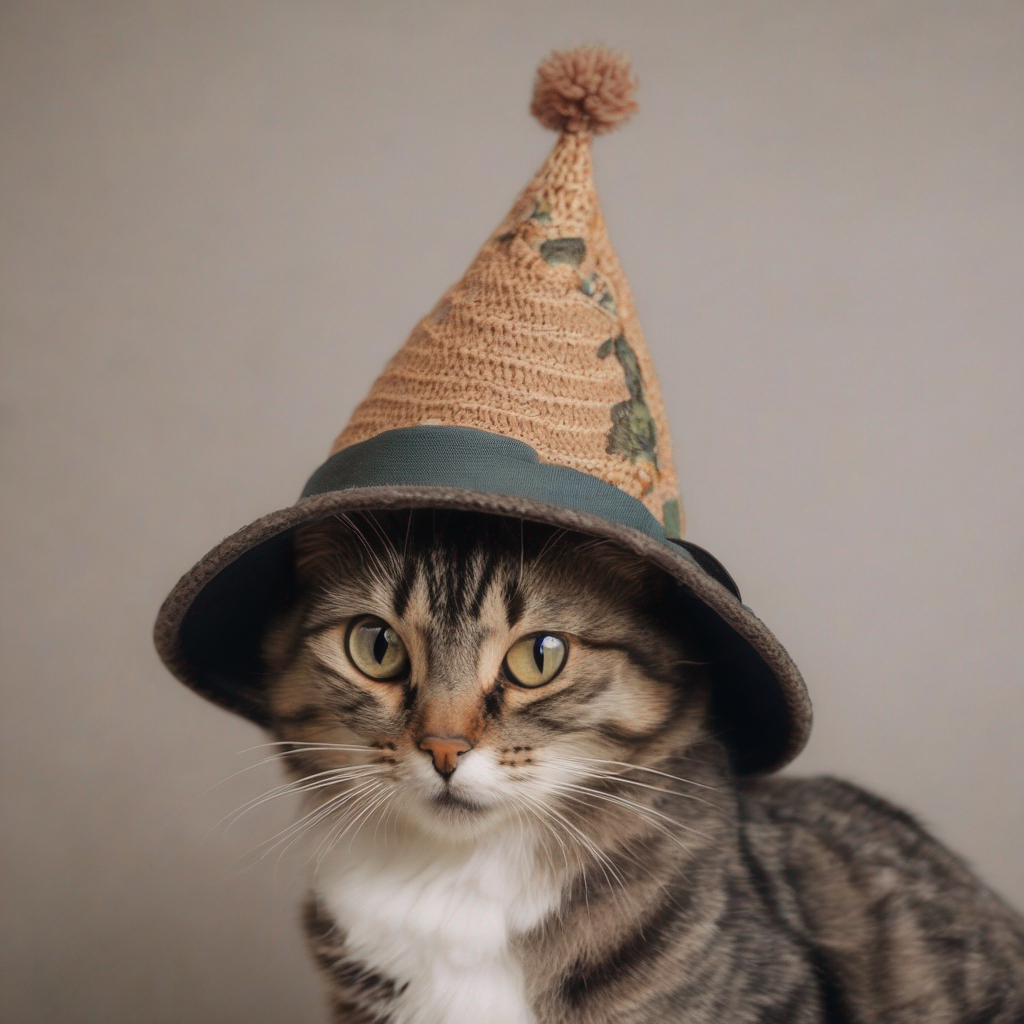

In [2]:
# text to image
text = "A photo of a cat with a hat"
output = text2img(text, num_inference_steps=24)
img = output.images[0]
display(img)

## Image2Image Generation Test

We will use the previously generated image as the input for the next step.
Here we will try to change the subject of a cat to a dog, while keeping the non-cat parts of the image the same.

In [3]:
# image to image
prompt = "dog"
# use image of cat as input

from diffusers import StableDiffusionXLImg2ImgPipeline

img2img = StableDiffusionXLImg2ImgPipeline(**text2img.components)



100%|██████████| 11/11 [00:03<00:00,  2.99it/s]


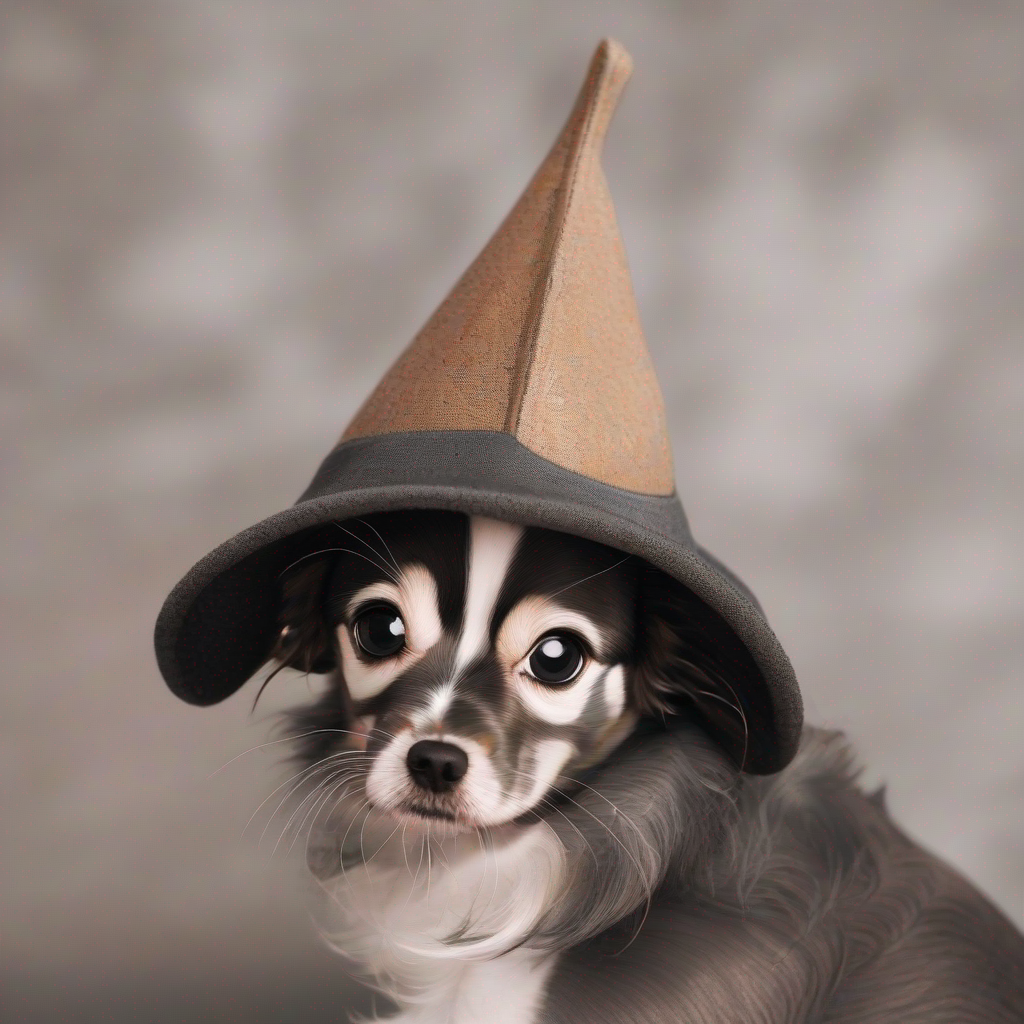

In [4]:
img2 = img2img(prompt, strength=0.7, guidance_scale=12, num_inference_steps=16, image=img).images[0]
display(img2)

## LoRA Test

In this step we will load a pre-trained LoRA and use it to generate an image from a text description.
To compare results, we will use the same settings, including the seed for the random number generator.
Since the LoRA changes the weights of the network (or at least the values of the latent space, depending on the implementation), the same seed as before will not produce the same result.

100%|██████████| 16/16 [00:04<00:00,  3.32it/s]


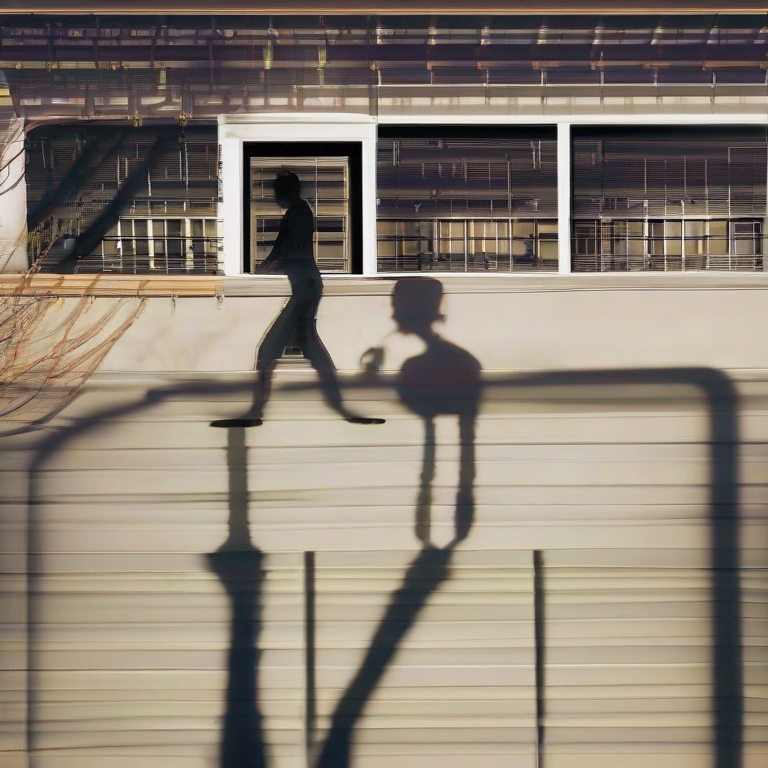

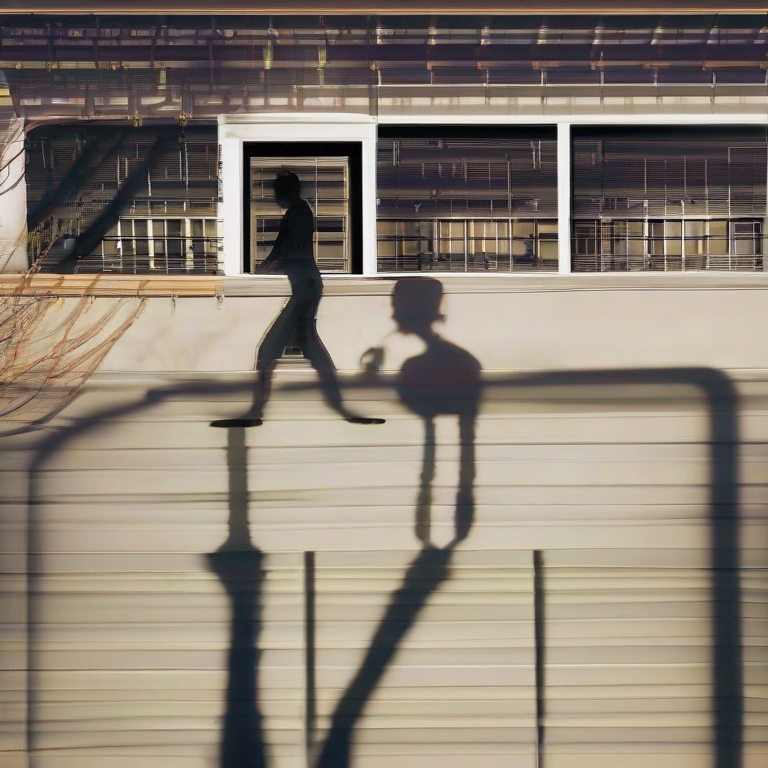

In [13]:
# test 3rd party lora
# see: https://huggingface.co/docs/diffusers/en/training/lora


# try this lora from civitai: https://civitai.com/models/131336/flowers-and-shadow-sdxl
# trigger word: "Flower shadow"
seed = 42
generator = torch.manual_seed(seed)
# first run before loading weights
# run twice to see if results are consistent
# smaller image size to speed up generation
no_lora_1 = text2img("Flower shadow", num_inference_steps=16, generator=generator, width=768, height=768).images[0]
generator = torch.manual_seed(seed)
no_lora_2 = text2img("Flower shadow", num_inference_steps=16, generator=generator, width=768, height=768).images[0]

display(no_lora_1)
display(no_lora_2)



The same seed resulted in the same generated image. In the next test we will load a LoRA and generate an image with the same seed. Since this
changes the model, we expect the generated image to be different if the LoRA was loaded correctly.

c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\diffusers\loaders\lora.py:805: FutureWarning: `_modify_text_encoder` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_modify_text_encoder", "0.27", LORA_DEPRECATION_MESSAGE)
c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\diffusers\loaders\lora.py:777: FutureWarning: `_remove_text_encoder_monkey_patch_classmethod` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_remove_text_encoder_monkey_patch_classmethod", "0.27", LORA_DEPRECATION_MESSAGE)
100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


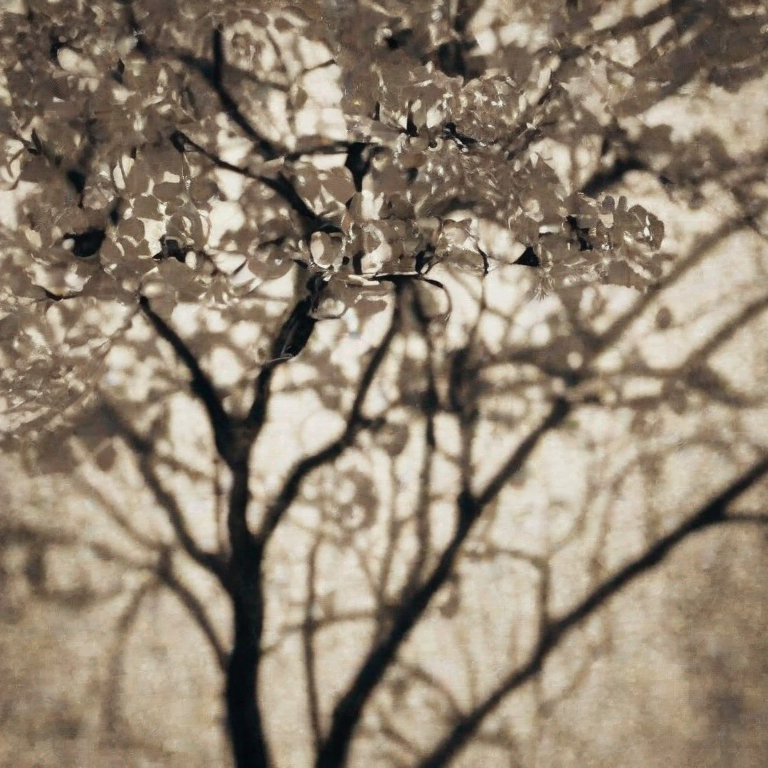

In [14]:
# download this if you don't have it
text2img.load_lora_weights("models/SDXL_flower_shadow_Sa_May_V3.safetensors")

generator = torch.manual_seed(seed)
lora_1 = text2img("Flower shadow", num_inference_steps=16, generator=generator, width=768, height=768).images[0]
display(lora_1)

## LoRA Training

In this step we will train a LoRA from scratch and then use it to generate an image from a text description. We will also save the trained LoRA to disk.

The training set will be a small sample of fruit images consisting of strawberries, bananas, watermelons, blueberries, and peaches.
The full dataset can be found [here](https://www.vicos.si/resources/fids30/).

In [4]:


from train_text_to_image_lora_sdxl import main as train_lora, parse_args
import sys
print(sys.argv)
args = parse_args()
print(args)

['c:\\Users\\Ben\\.conda\\envs\\sdxl\\Lib\\site-packages\\ipykernel_launcher.py', '--f=c:\\Users\\Ben\\AppData\\Roaming\\jupyter\\runtime\\kernel-v2-256321X6GNnQ4x4aa.json']


usage: ipykernel_launcher.py [-h] --pretrained_model_name_or_path
                             PRETRAINED_MODEL_NAME_OR_PATH
                             [--pretrained_vae_model_name_or_path PRETRAINED_VAE_MODEL_NAME_OR_PATH]
                             [--revision REVISION] [--variant VARIANT]
                             [--dataset_name DATASET_NAME]
                             [--dataset_config_name DATASET_CONFIG_NAME]
                             [--train_data_dir TRAIN_DATA_DIR]
                             [--image_column IMAGE_COLUMN]
                             [--caption_column CAPTION_COLUMN]
                             [--validation_prompt VALIDATION_PROMPT]
                             [--num_validation_images NUM_VALIDATION_IMAGES]
                             [--validation_epochs VALIDATION_EPOCHS]
                             [--max_train_samples MAX_TRAIN_SAMPLES]
                             [--output_dir OUTPUT_DIR] [--cache_dir CACHE_DIR]
                       

SystemExit: 2

c:\Users\Ben\.conda\envs\sdxl\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:

# make sure enough memory is available

# start training script
!accelerate launch diffusers/examples/text_to_image/train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --train_data_dir="data/fruits/" --caption_column="text" \
  --resolution=1024  \
  --train_batch_size=1 \
  --num_train_epochs=2 \
  --checkpointing_steps=2 \
  --learning_rate=1e-04 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --max_train_steps=20 \
  --validation_epochs=20 \
  --seed=1234 \
  --output_dir="loras" \
  --validation_prompt="fruits123" 

C:\Users\Ben\Documents\code\py\sdxl-lora-pipeline\source\diffusers\src\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
02/03/2024 15:19:48 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'rescale_betas_zero_snr', 'variance_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'thresholding'} was not found in config. Values will be initialized to default values.
{'dropout', 'reverse_transformer_layers_per_b